In [19]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets.data_handler import DataHandler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Two datasets experiment

In [20]:
data_handler = DataHandler()

#### MNIST
# Load the data and split it between train and test sets
(x_train, y_train), (x_id, y_ood) = data_handler.load("mnist")
#### Fashion MNIST

# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = data_handler.load("fashion_mnist")

x, labels = data_handler.merge(x_id, x_ood)


In [21]:

model = get_model("../saved_models/mnist_model")

### MLS

{'auroc': 0.9947957849999999}


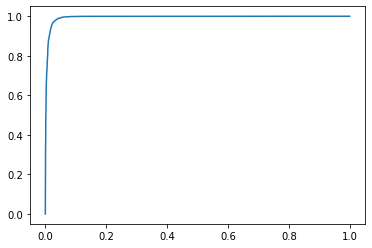

In [22]:

%autoreload 2

oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
auroc = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

{'auroc': 0.791859}


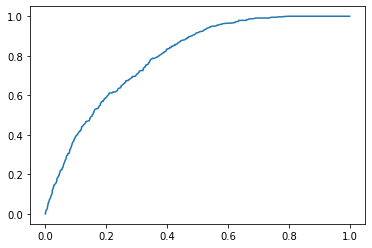

In [23]:
%autoreload 2

## This time need a dataset to fit KNN score
x, labels = data_handler.merge(x_id[:1000], x_ood[:1000])

oodmodel = DKNN()
oodmodel.fit(model, x_train[:10000])
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
auroc = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

def training_mnist(train_data, config=None):
    x_train, y_train = train_data
    input_shape = (28, 28, 1)
    num_classes=np.unique(y_train).shape[0]

    y_train = keras.utils.to_categorical(y_train, num_classes)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    batch_size = 128
    epochs = 5

    # compile and fit
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)    

    return model


In [25]:
data_handler = DataHandler()

(x_train, y_train), (x_test, y_test) = data_handler.load("mnist")

inc_labels = [0, 1, 2, 3, 4]

# Here we have to filter x_test to obtain x_id and x_ood
(x_train_id, y_train_id), _ = data_handler.filter(x_train, y_train, inc_labels=inc_labels) 
(x_id, y_id), (x_ood, y_ood) = data_handler.filter(x_test, y_test, inc_labels=inc_labels) 


In [26]:

model = training_mnist(train_data=(x_train_id, y_train_id))

Epoch 1/5
216/216 [==============================] - 10s 41ms/step - loss: 0.2354 - accuracy: 0.9285 - val_loss: 0.0425 - val_accuracy: 0.9879
Epoch 2/5
216/216 [==============================] - 9s 40ms/step - loss: 0.0572 - accuracy: 0.9818 - val_loss: 0.0313 - val_accuracy: 0.9912
Epoch 3/5
216/216 [==============================] - 8s 38ms/step - loss: 0.0425 - accuracy: 0.9870 - val_loss: 0.0264 - val_accuracy: 0.9954
Epoch 4/5
216/216 [==============================] - 8s 39ms/step - loss: 0.0347 - accuracy: 0.9896 - val_loss: 0.0205 - val_accuracy: 0.9951
Epoch 5/5
216/216 [==============================] - 9s 40ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.0198 - val_accuracy: 0.9958


## MLS

{'auroc': 0.9370651814548355}


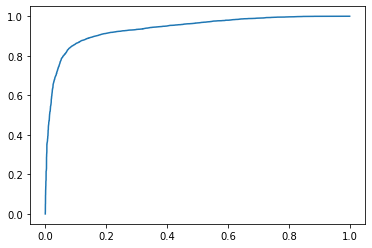

In [27]:
%autoreload 2


x, labels = data_handler.merge(x_id, x_ood)

oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
auroc = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

{'auroc': 0.9269745}


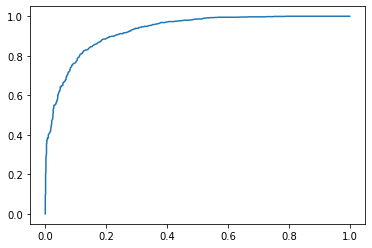

In [28]:
%autoreload 2

x, labels = data_handler.merge(x_id[:1000], x_ood[:1000])

oodmodel = DKNN()
oodmodel.fit(model, x_train_id[:10000])
scores = oodmodel.score(x)

fpr, tpr = get_curve(scores, labels)
auroc = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()